In [4]:
import pandas as pd

# read in

In [5]:
df = pd.read_csv('../../2_Feature_Engineering/export/combined_polly_bretschneider_iwg.csv')
df.head()

,raw_text,severity,binary_label
0,ist ekelhaft bei ihren Klos kannst du nur mit...,0.0,False
1,Bevor Sie mit Jud...,1.0,True
2,Und de Amis freut es wenn die Heuschrecken Eur...,0.0,False
3,": Die Krim ist ein heißer Tip, auch zum In...",1.0,True
4,: Es muss in #Deutschland eine politische Kra...,1.0,True


# clean

In [6]:
import sys
sys.path.insert(0, r'..\..\0_common')
from model_helpers import clean_all as ci

In [7]:
df['cleaned_text'] = df['raw_text'].apply(ci)
df.head()

,raw_text,severity,binary_label,cleaned_text
0,ist ekelhaft bei ihren Klos kannst du nur mit...,0.0,False,ekelhaft klos kannst gummistiefel gehen stinkt...
1,Bevor Sie mit Jud...,1.0,True,bevor judenstern markiert worden juden ganze ...
2,Und de Amis freut es wenn die Heuschrecken Eur...,0.0,False,de amis freut heuschrecken europa klein wirtsc...
3,": Die Krim ist ein heißer Tip, auch zum In...",1.0,True,krim heißer tip investieren muß bürger landes...
4,: Es muss in #Deutschland eine politische Kra...,1.0,True,deutschland politische kraft geben sozial sch...


In [8]:
df.shape

(9169, 4)

# vectorize

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vec = CountVectorizer(ngram_range=(2,5), analyzer='char_wb', max_features=100000)

In [11]:
X_features = vec.fit_transform(df['cleaned_text'])

In [12]:
X_features.shape

(9169, 75428)

# Train/Test Split

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_features, df['binary_label'], stratify=df['binary_label'], shuffle=True)

# base model

In [16]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
model_res = clf.fit(X_train, y_train)

C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_auc_score
y_pred = model_res.predict(X_test)

print('F1:', f1_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('auc: ', roc_auc_score(y_test, y_pred))

F1: 0.9006010171058716
Recall:  0.9018518518518519
Confusion Matrix:
 [[1104  109]
 [ 106  974]]
auc:  0.9059960001221337


# tune model

In [34]:
from sklearn.model_selection import GridSearchCV
import numpy as np

params = [
    {
     'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}]

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

clf = LogisticRegression()

refit_score = 'recall_score'

grid_search = GridSearchCV(clf, param_grid=params, return_train_score=True, cv=5, scoring=scorers, 
                   verbose=True, n_jobs=-1, refit=refit_score)
grid_search.fit(X_train, y_train)

# best params
print('Best params for {}'.format(refit_score))
print(grid_search.best_params_)

# confusion matrix on the test data.
y_pred = grid_search.predict(X_test)
print('\nConfusion matrix of Logistic Regression optimized for {} on the test data:'.format(refit_score))
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.5s


Best params for recall_score
{'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       607       606
pos        59      1021


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   47.4s finished


In [38]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_precision_score,split1_test_precision_score,...,mean_test_accuracy_score,std_test_accuracy_score,rank_test_accuracy_score,split0_train_accuracy_score,split1_train_accuracy_score,split2_train_accuracy_score,split3_train_accuracy_score,split4_train_accuracy_score,mean_train_accuracy_score,std_train_accuracy_score
0,0.224625,0.012916,0.023736,0.006445,0.0001,l1,liblinear,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.000000,0.000000,...,0.528941,0.000175,39,0.528909,0.528909,0.528995,0.528995,0.528899,0.528941,0.000044
1,0.449420,0.023455,0.016954,0.001994,0.0001,l2,liblinear,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.601162,0.597059,...,0.675684,0.009743,36,0.680364,0.694727,0.686421,0.690965,0.684478,0.687391,0.005008
2,0.224798,0.008979,0.016956,0.001093,0.000263665,l1,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l1',...",0.000000,0.000000,...,0.528941,0.000175,39,0.528909,0.528909,0.528995,0.528995,0.528899,0.528941,0.000044
3,0.517613,0.014699,0.018750,0.000745,0.000263665,l2,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l2',...",0.709914,0.683957,...,0.762653,0.012824,34,0.777091,0.786909,0.780404,0.780040,0.784260,0.781741,0.003446
4,0.327723,0.015212,0.016955,0.001786,0.000695193,l1,liblinear,"{'C': 0.0006951927961775605, 'penalty': 'l1', ...",0.541899,0.542373,...,0.601076,0.006746,37,0.602727,0.602727,0.601527,0.600073,0.598328,0.601076,0.001686


In [41]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_precision_score', 'split1_test_precision_score',
       'split2_test_precision_score', 'split3_test_precision_score',
       'split4_test_precision_score', 'mean_test_precision_score',
       'std_test_precision_score', 'rank_test_precision_score',
       'split0_train_precision_score', 'split1_train_precision_score',
       'split2_train_precision_score', 'split3_train_precision_score',
       'split4_train_precision_score', 'mean_train_precision_score',
       'std_train_precision_score', 'split0_test_recall_score',
       'split1_test_recall_score', 'split2_test_recall_score',
       'split3_test_recall_score', 'split4_test_recall_score',
       'mean_test_recall_score', 'std_test_recall_score',
       'rank_test_recall_score', 'split0_train_recall_score',
       'split1_train_recall_score', 'split2_train_recall_score',
       

In [42]:
results =results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'params']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,params
17,0.897,0.882,0.897,"{'C': 0.23357214690901212, 'penalty': 'l2', 's..."
19,0.895,0.882,0.896,"{'C': 0.615848211066026, 'penalty': 'l2', 'sol..."
23,0.894,0.880,0.894,"{'C': 4.281332398719396, 'penalty': 'l2', 'sol..."
15,0.893,0.875,0.892,"{'C': 0.08858667904100823, 'penalty': 'l2', 's..."
21,0.892,0.881,0.894,"{'C': 1.623776739188721, 'penalty': 'l2', 'sol..."


0.7228912857622668


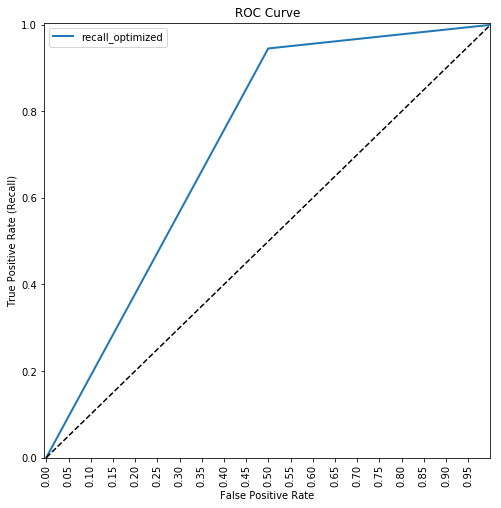

In [55]:
%matplotlib inline

def plot_roc_curve(fpr, tpr, label=None):
    
    import matplotlib.pyplot as plt
    
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

from model_helpers import plot_roc_curve

fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [64]:
from sklearn.model_selection import GridSearchCV
import numpy as np

params = [
    {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear', 'lbfgs', 'newton-cg']}]

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

clf = LogisticRegression()

refit_score = 'recall_score'

grid_search = GridSearchCV(clf, param_grid=params, return_train_score=True, cv=5, scoring=scorers, 
                   verbose=True, n_jobs=-1, refit=refit_score, error_score=np.nan)
grid_search_result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min


Best params for recall_score
{'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       607       606
pos        59      1021


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.1min finished
C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# best params
print('Best params for {}'.format(refit_score))
print(grid_search_result.best_params_)

# confusion matrix on the test data.
y_pred = grid_search_result.predict(X_test)
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 

In [65]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_precision_score,split1_test_precision_score,...,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.253123,0.007007,0.038898,0.004763,0.0001,l1,liblinear,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.000000,0.000000,...,0.500000,0.000000,79,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
1,0.057845,0.004369,0.000000,0.000000,0.0001,l1,lbfgs,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,...,NaN,NaN,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.064425,0.008956,0.000000,0.000000,0.0001,l1,newton-cg,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'newt...",NaN,NaN,...,NaN,NaN,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.479715,0.017750,0.031317,0.001492,0.0001,l2,liblinear,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.601162,0.597059,...,0.690828,0.009506,76,0.695429,0.709008,0.701514,0.705344,0.699357,0.702131,0.004703
4,1.014684,0.035629,0.040893,0.007777,0.0001,l2,lbfgs,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.754816,0.739051,...,0.728342,0.014402,74,0.733938,0.736899,0.736520,0.730366,0.734187,0.734382,0.002335


In [74]:
results.mean_train_f1.unique()

array([1.        , 0.99996141, 0.99976843, 0.99849329, 0.99829977,
       0.99826109, 0.994149  , 0.99399514, 0.99305778, 0.99301883,
       0.98081369, 0.97869355, 0.96258011, 0.95837836, 0.95372413,
       0.92689976, 0.91471913, 0.9146336 , 0.90197669, 0.89450575,
       0.87883714, 0.87879247, 0.86502262, 0.84508056, 0.83344562,
       0.83176638, 0.80193305, 0.79618782, 0.78527021, 0.76197987,
       0.74251042, 0.73846988, 0.71941286, 0.70184789, 0.68475501,
       0.68018834, 0.        ,        nan])

In [69]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_precision_score', 'split1_test_precision_score',
       'split2_test_precision_score', 'split3_test_precision_score',
       'split4_test_precision_score', 'mean_test_precision_score',
       'std_test_precision_score', 'rank_test_precision_score',
       'split0_train_precision_score', 'split1_train_precision_score',
       'split2_train_precision_score', 'split3_train_precision_score',
       'split4_train_precision_score', 'mean_train_precision_score',
       'std_train_precision_score', 'split0_test_recall_score',
       'split1_test_recall_score', 'split2_test_recall_score',
       'split3_test_recall_score', 'split4_test_recall_score',
       'mean_test_recall_score', 'std_test_recall_score',
       'rank_test_recall_score', 'split0_train_recall_score',
       'split1_train_recall_score', 'split2_train_recall_score',
       

In [72]:
results =results.sort_values(by=[ 'mean_train_f1', 'mean_test_recall_score'], ascending=[False, False])
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_train_f1', 'mean_train_roc_auc', 'params']].round(3).head(10)

,mean_test_precision_score,mean_test_recall_score,mean_train_f1,mean_train_roc_auc,params
76,0.893,0.882,1.0,1.0,"{'C': 11.288378916846883, 'penalty': 'l2', 'so..."
82,0.892,0.882,1.0,1.0,"{'C': 29.763514416313132, 'penalty': 'l2', 'so..."
118,0.886,0.881,1.0,1.0,"{'C': 10000.0, 'penalty': 'l2', 'solver': 'lbf..."
106,0.886,0.881,1.0,1.0,"{'C': 1438.44988828766, 'penalty': 'l2', 'solv..."
69,0.894,0.880,1.0,1.0,"{'C': 4.281332398719396, 'penalty': 'l2', 'sol..."
71,0.894,0.880,1.0,1.0,"{'C': 4.281332398719396, 'penalty': 'l2', 'sol..."
88,0.890,0.879,1.0,1.0,"{'C': 78.47599703514607, 'penalty': 'l2', 'sol..."
94,0.889,0.879,1.0,1.0,"{'C': 206.913808111479, 'penalty': 'l2', 'solv..."
112,0.887,0.878,1.0,1.0,"{'C': 3792.690190732246, 'penalty': 'l2', 'sol..."
100,0.888,0.878,1.0,1.0,"{'C': 545.5594781168514, 'penalty': 'l2', 'sol..."


0.7228912857622668


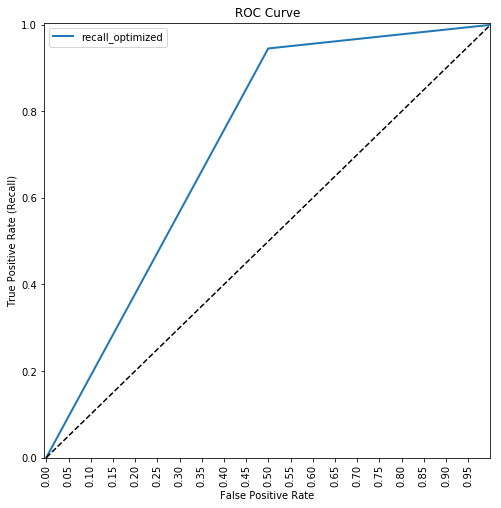

In [73]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

# ON F1 just to try

In [81]:
from sklearn.model_selection import GridSearchCV
import numpy as np

params = [
    {
    'penalty' : ['l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear', 'lbfgs', 'newton-cg']}]

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

clf = LogisticRegression()

grid_search_f = GridSearchCV(clf, param_grid=params, return_train_score=True, cv=5, scoring=scorers, 
                   verbose=True, n_jobs=-1, refit='f1', error_score=np.nan)
grid_search_result_f = grid_search_f.fit(X_train, y_train)

grid_search_prec = GridSearchCV(clf, param_grid=params, return_train_score=True, cv=5, scoring=scorers, 
                   verbose=True, n_jobs=-1, refit='precision_score', error_score=np.nan)
grid_search_result_prec = grid_search_prec.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished
C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [86]:
grid_search_recall = GridSearchCV(clf, param_grid=params, return_train_score=True, cv=5, scoring=scorers, 
                   verbose=True, n_jobs=-1, refit='recall_score', error_score=np.nan)
grid_search_result_recall = grid_search_recall.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


In [93]:
def plot_roc_curve(fpr, tpr, label=None):
    import matplotlib.pyplot as plt
    
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

    return plt

In [82]:
# best params
print('Best params for {}'.format('f1'))
print(grid_search_result_f.best_params_)

# confusion matrix on the test data.
y_pred = grid_search_result_f.predict(X_test)
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format('f1'))
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 

Best params for f1
{'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1113       100
pos       105       975


In [85]:
# best params
print('Best params for {}'.format('prec'))
print(grid_search_result_prec.best_params_)

# confusion matrix on the test data.
y_pred = grid_search_result_prec.predict(X_test)
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format('prec'))
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 

Best params for auc
{'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'lbfgs'}

Confusion matrix of Random Forest optimized for prec on the test data:
     pred_neg  pred_pos
neg      1112       101
pos       110       970


In [87]:
# best params
print('Best params for {}'.format('recall'))
print(grid_search_result_recall.best_params_)

# confusion matrix on the test data.
y_pred = grid_search_result_recall.predict(X_test)
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format('recall'))
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 

Best params for recall
{'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}

Confusion matrix of Random Forest optimized for recall on the test data:
     pred_neg  pred_pos
neg       607       606
pos        59      1021


0.7228912857622668
0.9074417575035877
0.9101687734725656


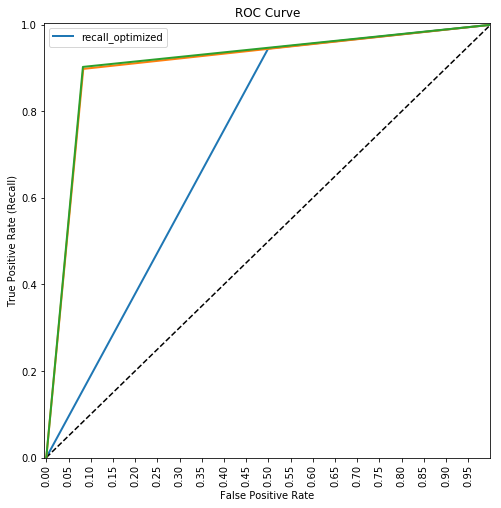

In [94]:
fpr, tpr, auc_thresholds = roc_curve(y_test, grid_search_result_recall.predict(X_test))
print(auc(fpr, tpr)) # AUC of ROC
plt = plot_roc_curve(fpr, tpr, 'recall_optimized')

fpr, tpr, auc_thresholds = roc_curve(y_test, grid_search_result_prec.predict(X_test))
print(auc(fpr, tpr)) # AUC of ROC
plt.plot(fpr, tpr, linewidth=2, label='prec_optimized')

fpr, tpr, auc_thresholds = roc_curve(y_test, grid_search_result_f.predict(X_test))
print(auc(fpr, tpr)) # AUC of ROC
plt.plot(fpr, tpr, linewidth=2, label='f1_optimized')

In [95]:
f1_score(y_test, grid_search_result_f.predict(X_test))

0.9048723897911833

In [96]:
X_test[(y_test == 1) & (y_pred[:,0].T == 0)]
X_test[(y_test == 0) & (y_pred[:,0].T == 1)]

IndexError: too many indices for array

In [100]:
y_pred = grid_search_result_f.predict(X_test)

In [136]:
false_negatives = []
false_positives = []

y_test_indices, y_test_items = zip(*list(y_test.items()))

for i in range(len(y_pred)):
    #print(y_pred[i], y_test_indices[i], y_test_items[i])
    if y_pred[i] == True and y_test_items[i] == False:
        #print('False Positive\n-----')
        false_positives.append(y_test_indices[i])
    if y_pred[i] == False and y_test_items[i] == True:
        #print('False Negative\n----')        
        false_negatives.append(y_test_indices[i])

print(len(false_negatives), len(false_positives))

105 100


# False Negatives

Vom Modell nicht erkannte Hasskommentare

In [137]:
df.iloc[false_negatives]

,raw_text,severity,binary_label,cleaned_text
7377,: Ministerium alarmiert - 7600 Apotheken steh...,1.0,True,ministerium alarmiert 7600 apotheken stehen d...
5810,SPD-Politiker kritisieren Gabriels Leitkultur-...,1.0,True,spdpolitiker kritisieren gabriel leitkulturvor...
2475,Minderwertige Nutte!,1.0,True,minderwertige nutte
4785,": Wer sein eigenes Volk verrät ,dessen Wort...",1.0,True,wer eigenes volk verrät worte vertrauen
1742,: Für mich kein Problem.\r\r\nIch stehe zu...,1.0,True,problem stehe sage schreibe gegensatz deutsch...
7805,#CDUCSU #Linke #Gruene #SPD ihr seid so bi...,1.0,True,cducsu linke gruene spd seid billig doof unfäh...
1024,Schweine eben,1.0,True,schweine eben
5509,langsam reichts. prügelt diese untermenschen i...,1.0,True,langsam reichts prügelt untermenschen gulli or...
1537,Dann bin ich wohl raus bei dir😏,1.0,True,wohl raus
7053,Deutschland und die Sicherheit,1.0,True,deutschland sicherheit


# False positives
Vom Modell fälschlicherweise als Hasskommentare eingestuft

In [140]:
df.iloc[false_positives]

,raw_text,severity,binary_label,cleaned_text
1098,Sie soll sich wie damals die Honnecker verpiss...,0.0,False,damals honnecker verpissen paraguay gibt genug...
8003,"Da sitzen sie mit knallroten Köpfen, unsere ac...",0.0,False,sitzen knallroten köpfen ach fähigen landesobe...
1865,Schließen und die ganze Familie und Verwanten ...,0.0,False,schließen ganze familie verwanten sofort absch...
5808,Wie waere es denn mit bio fotos die in eine da...,0.0,False,waere bio fotos datenbank kommenwie beim perso...
781,Hallo ich bin pullitischeFlüchtlinge unt suche...,0.0,False,hallo pullitischeflüchtlinge unt suche eihne d...
1202,Kamera übewachung.\r\r\nNicht nur millionen fü...,0.0,False,kamera übewachung millionen flüchtlinge ausgeb...
971,Mein Vorschlag er und die Le Pen im tausch geg...,0.0,False,vorschlag le pen tausch merkel gabriel
6753,Das dümmste Land auf diesen Planeten ist Deuts...,0.0,False,dümmste land planeten deutschland
1218,und wer finanzierts... wir!!! Wir das arbeiten...,0.0,False,wer finanzierts arbeitende deutsche volk dürfe...
5852,Damit sie sich an ihren Händen nicht verletzen...,0.0,False,händen verletzen sollten gutmenschen reichlich...
